In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Do I need this?
#from pathlib import Path

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
#hawaii_path = Path("../Resources/hawaii.sqlite")
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
#engine = create_engine(f"sqlite:///{hawaii_path}")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine,reflect=True)
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Query All Records in Hawaii measurement file
#measurement = pd.read_sql("SELECT * FROM measurement;", conn)
#measurement.head()  
measurement = base.classes.measurement

In [8]:
# Query All Records in Hawaii station file
#station = pd.read_sql("SELECT * FROM station;", conn)
#station.head()  
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# most_recent = measurement["date"].max()

most_recent = engine.execute("SELECT MAX(date) FROM measurement;")

for m in most_recent:
    print(m)

('2017-08-23',)


Text(0.5, 1.0, 'Precipitation data from 8/23/2016 to 8/23/2017')

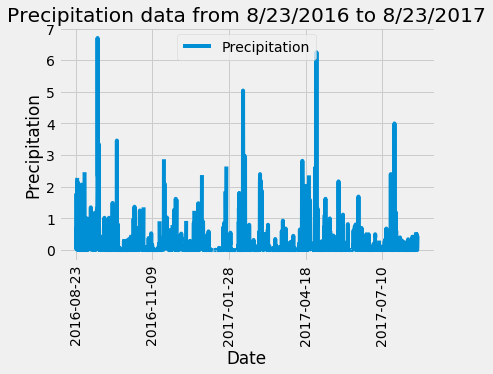

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year = dt.date(2017,8,23)-dt.timedelta(days=365)
#last_year = datetime.strptime(last_year,"%y-%m-%d")
#last_year

# Perform a query to retrieve the data and precipitation scores
#prcp_data = measurement[measurement["date"] >= last_year]
prcp_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("Date")
#prcp_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x="Date", y="Precipitation", rot=90)

plt.ylabel('Precipitation')
plt.title('Precipitation data from 8/23/2016 to 8/23/2017')

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data 
#prcp_df.agg({"Precipitation":['count', 'mean', 'median', 'var', 'std', 'sem', 'min', 'max']}) 
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
num_stations = engine.execute("SELECT DISTINCT COUNT(*) FROM station;")
for s in num_stations:
    print(s)

(9,)


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)

# List the stations and their counts in descending order.

sql_statement_1 = """SELECT station, COUNT(*) AS station_count
FROM measurement
GROUP BY station
ORDER BY station_count DESC;
"""

most_active_df = pd.read_sql(sql_statement_1,engine)
most_active_df

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sql_statement_2 = """SELECT station AS station_ID, MIN(tobs) AS lowest_temp, MAX(tobs) AS highest_temp, AVG(tobs) AS average_temp
FROM measurement
WHERE station = 'USC00519281'
;"""

station_info_df = pd.read_sql(sql_statement_2,engine)
station_info_df

,station_ID,lowest_temp,highest_temp,average_temp
0,USC00519281,54.0,85.0,71.663781


In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 

sql_statement_3 = """SELECT date, tobs
FROM measurement
WHERE station = 'USC00519281'
AND date BETWEEN '2016-08-23' AND '2017-08-23'
ORDER BY date;"""

last_year_temps = pd.read_sql(sql_statement_3,engine)
last_year_temps.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


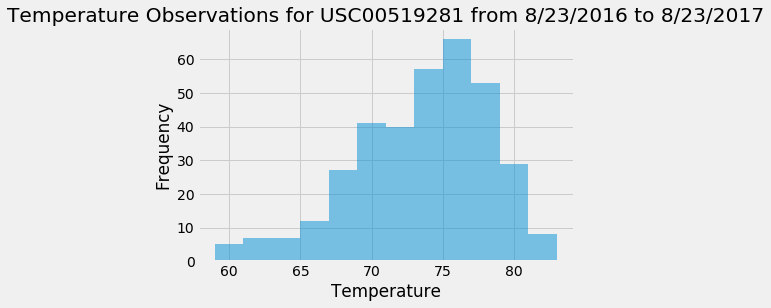

In [17]:
# Plot the results as a histogram
plt.hist(last_year_temps['tobs'], bins=12, alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations for USC00519281 from 8/23/2016 to 8/23/2017')
plt.show()

# Close Session

In [19]:
# Close Session
session.close()